# Covid-19 infección en Ecuador. Modelos probabilisticos
Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [56]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline




In [57]:
# Actualizar los datos (URL)
url = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'
df = pd.read_csv(url)
df

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,2020-01-03,17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2020-04-20,74142,88.0,14.0,94.0,9.0,0.0,0.0,0.0,102.0,...,24601,0.0,11.0,70.0,0.0,29.0,0.0,0.0,4.0,0.0
112,2020-04-21,77274,35.0,22.0,89.0,4.0,0.0,0.0,0.0,90.0,...,28065,1.0,7.0,92.0,1.0,0.0,0.0,0.0,4.0,0.0
113,2020-04-22,87387,61.0,25.0,93.0,0.0,0.0,0.0,1.0,112.0,...,37289,0.0,8.0,35.0,0.0,29.0,0.0,0.0,0.0,3.0
114,2020-04-23,67629,84.0,25.0,99.0,6.0,0.0,0.0,0.0,144.0,...,17588,0.0,6.0,24.0,0.0,3.0,0.0,0.0,9.0,0.0


Imprimos los resultados y agregamos el numero del dia


In [58]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

,date,Ecuador
0,-1,0.0
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
...,...,...
111,110,446.0
112,111,660.0
113,112,270.0
114,113,452.0


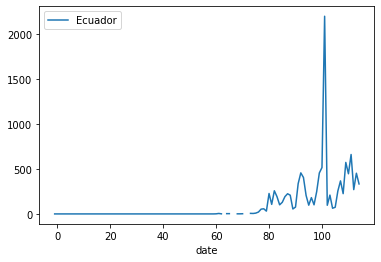

In [59]:
df.plot(x ='date', y='Ecuador')

Ahora podemos analizar un modelo probabilisto para el examen.

## El modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.



In [60]:
filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print(mediana)
print(media)


155.0
223.66


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [71]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

11338


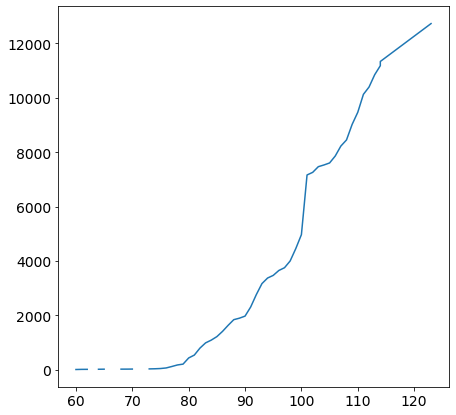

Estimado 12733
Resultado YR
[1.0, 6.0, 7.0, 0, 10.0, 13.0, 0, 0, 14.0, 15.0, 17.0, 0, 0, 23.0, 28.0, 37.0, 58.0, 111.0, 168.0, 199.0, 426.0, 532.0, 789.0, 981.0, 1082.0, 1211.0, 1403.0, 1627.0, 1835.0, 1890.0, 1966.0, 2302.0, 2758.0, 3163.0, 3368.0, 3465.0, 3646.0, 3747.0, 3995.0, 4450.0, 4965.0, 7161.0, 7257.0, 7466.0, 7529.0, 7603.0, 7858.0, 8225.0, 8450.0, 9022.0, 9468.0, 10128.0, 10398.0, 10850.0, 11183.0]
Resultado XR
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]


In [72]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.
xp=np.zeros(len(x[61:]))
yp=np.zeros(len(y[61:]))
xr=np.zeros(len(x[61:]))
yr=np.zeros(len(y[61:]))

xp=x[61:]
yp=y[61:]
xr=x[61:]
yr=y[61:]
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

print("Estimado",y[-1])

yr[3]=0
yr[6]=0
yr[7]=0
yr[11]=0
yr[12]=0
yp[3]=0
yp[6]=0
yp[7]=0
yp[11]=0
yp[12]=0
print("Resultado YR")
print(yr)
print("Resultado XR")
print(xr)

# Practica

1. Comparar el modelo de predicion matematico vs probabilidad.
2. Generar el SIR en base al modelo de probabilidad y obtener beta y gamma con una semana de prediccion.
3. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

Puntos extras: Investigas sobre la correlacion de variables y aplicar el calculo en base a los datos del Ecuador.

# Implementar
# 1. Comparar el modelo de predicion matematico vs probabilidad.
Comparacion con el Modelo Polinomial en una prediccion de una semana

Prediccion Estimada 11305.34420951843


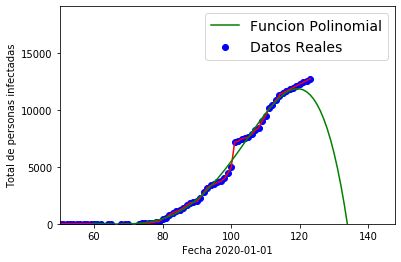

In [8]:
# Modelo Polinomial
datos = {}
# Definir los puntos
for dias in range(1,6):
    z = np.polyfit(xr, yr, dias, full=True)
    datos[dias] = z
plt.plot(x, y, 'r')
# RAGO
xp=np.array(range(60,200))
# fUNCION POLINOMIAL
for dias, escala in datos.items():
    coefs, error, *_ = escala
    p = np.poly1d(coefs)
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
plt.scatter(x,y,label="Datos Reales",color="blue")
plt.plot(xp, p(xp), "-", label="Funcion Polinomial",color="green")
plt.legend()
plt.xlabel("Fecha 2020-01-01")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*(-1000),max(y)*1.5)) # Definir los limites de Y
plt.xlim((min(x)*(-50),max(x)*1.2))# Definir los limites de X
print("Prediccion Estimada",p(115))

# Generar el SIR en base al modelo de probabilidad y obtener beta y gamma con una semana de prediccion.

In [9]:
#Librerias
import numpy as np 
from datetime import datetime,timedelta
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import pandas as pd,requests,sys,numpy as np, matplotlib, math, matplotlib.pyplot as plt,scipy
from scipy.integrate import solve_ivp

from scipy.optimize import minimize
from IPython.display import display

In [10]:
#Prediccion a Una semana
xpredicct=np.zeros(len(x[61:]))
ypredicct=np.zeros(len(y[61:]))

for i in range(xr[-1], xr[-1]+7):
    x.append(i)
    y.append(int(yr[-1] + mediana))
print(len(yr))
print(len(xr))
print(yr)

55
55
[1.0, 6.0, 7.0, 0, 10.0, 13.0, 0, 0, 14.0, 15.0, 17.0, 0, 0, 23.0, 28.0, 37.0, 58.0, 111.0, 168.0, 199.0, 426.0, 532.0, 789.0, 981.0, 1082.0, 1211.0, 1403.0, 1627.0, 1835.0, 1890.0, 1966.0, 2302.0, 2758.0, 3163.0, 3368.0, 3465.0, 3646.0, 3747.0, 3995.0, 4450.0, 4965.0, 7161.0, 7257.0, 7466.0, 7529.0, 7603.0, 7858.0, 8225.0, 8450.0, 9022.0, 9468.0, 10128.0, 10398.0, 10850.0, 11183.0]


Resultado Beta: 
0.026805428596379077
Resultado Gamma: 
0.001
Resultado R0: 
26.805428596379077
Resultado Susceptibles: 
8.935060903649056
Resultado Recuperados: 
37891.64554409376


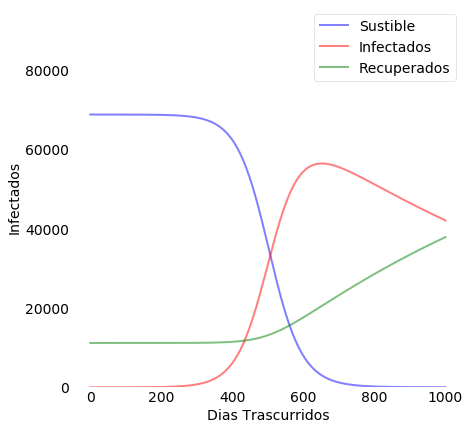

In [28]:
#La función de pérdida
def loss(point, data, rf, s_0, i_0, r_0):
     
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - rf)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

#Cargamos datos de la prediccion yr
data = (yr)

# Total de la poblacion
N = 80000
# Numero Inicial de Infectados
I0 = 1
# Numero de Recuperados
R0 = yr[len(yr)-1]
# Todos los demás, S0, son susceptibles a la infección inicialmente.
S0 = N - I0 - R0
optimal = minimize(loss, [0.0001, 0.0001], args=(data, 0, S0, I0, R0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
beta, gamma = optimal.x

beta *= 10000
gamma *= 100000 

print('Resultado Beta: ' )
print(beta)
print('Resultado Gamma: ')
print(gamma)
print("Resultado R0: ")
print(beta/gamma)
# Una cuadrícula de puntos de tiempo (en días)
t = np.linspace(0,1000, 10000)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
print("Resultado Susceptibles: ")
print(S[len(S)-1])
print("Resultado Recuperados: ")
print(R[len(R)-1])

fig = plt.figure(facecolor='w')

#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Dias Trascurridos')
ax.set_ylabel('Infectados')
ax.set_ylim(0,N*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

Resultado Prediccion menos 7 dias:  8225.0


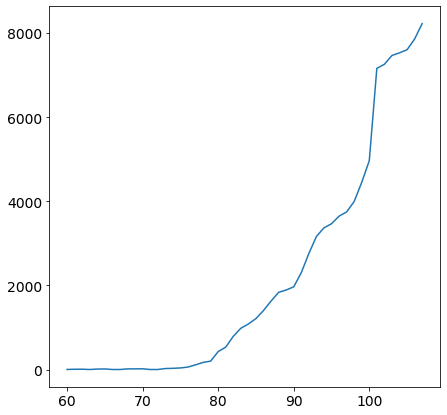

Nueva mediana:  97.0
Nueva media: 185.4390243902439


In [73]:
#Restamos una semana a los datos y calculamos
xA=np.zeros(len(xp)-7)
yA=np.zeros(len(yp)-7)
x_new=np.zeros(7)
y_new=np.zeros(7)
for i in range(len(xp)-7):
    xA[i]=xp[i]
    yA[i]=yp[i]
for i in range(7):
    x_new[i]=xp[48+i]
    y_new[i]=yp[48+i]
xprobable=np.zeros(len(xp))
yprobable=np.zeros(len(yp))
yprobable=yp
xprobable=xp
print("Resultado Prediccion menos 7 dias: ",yA[-1])
plt.plot(xA,yA)
plt.show()
filtroSemanaAtras = df["Ecuador"][61:107] # Filtro los datos que se empezo a tener casos

medianueva = filtroSemanaAtras.mean()
mediananueva = filtroSemanaAtras.median()
print("Nueva mediana: ",mediananueva)
print("Nueva media:" , medianueva)

# Con el modelo matematico polimonial

Prediccion Estimada 5487.472717557976


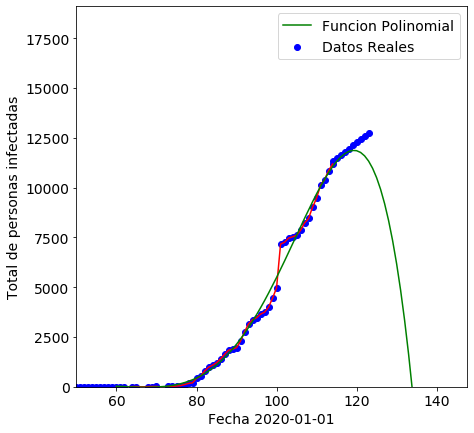

In [77]:
# Modelo Polinomial
datos = {}
# Definir los puntos
for dias in range(1,6):
    z = np.polyfit(xprobable, yprobable, dias, full=True)
    datos[dias] = z
plt.plot(xprobable, yprobable, 'r')
# RAGO
xprobable=np.array(range(60,200))
# fUNCION POLINOMIAL
for dias, escala in datos.items():
    coefs, error, *_ = escala
    p = np.poly1d(coefs)
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
plt.scatter(x,y,label="Datos Reales",color="blue")
plt.plot(xp, p(xp), "-", label="Funcion Polinomial",color="green")
plt.legend()
plt.xlabel("Fecha 2020-01-01")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*(-1000),max(y)*1.5)) # Definir los limites de Y
plt.xlim((min(x)*(-50),max(x)*1.2))# Definir los limites de X
print("Prediccion Estimada",p(100))

## Analisis
En base a los resultados obtenidos de los dos modelos apreciamos que el modelo probabilistico posee una mejor certeza en su prediccion ya que calculamos la mediana y obtenemo el valor medio de crecimiento de un conjunto de datoscon lo cual obtenemos un crecimiento o taza de crecimiento de los nuevos casos mas claro. Aun asi el modelo polinomial posee una curva de prediccion muy establ y presisa deacuerdo al grado del polinomio.

## Conclusiones
Podemos decir que los dos modelos tienes su ventaja deacuerdo a la manera que esperamos obtener la prediccion de nuestro datos, ya sea con el probabilistico que maneja mejor los datos con una media y mediana, o por otro lado el polinomial que presenta una curva muy presisa de los datos.

## Criterio personal (politico, economico y  social de la situacion)
En base a la situacion vista, no es sorpresa que la situacion del pais esta en grabe declive ya que en algunos casos las medidad establecidas por el gobierno estan mas rigurosas u/o estrictas debido al gran crecimiento casos que se esta dando, la situacion de las personas es bastante mala en unos por la falta de trabajo y otros por la falta de pagos de estos, por lo cual los recursos basicos se les hace complicado obtener debido a la falta de dinero que la mayoria sufrimos, por otro lado vemos falta de insumos medicos y inconformidad de la poblacion por malos tratos o despreocupacion de algunos centros, por ultimo decimos que como personas en general deberiamos comtar siempre con informacion verificada ya que esta corriendo mucha informacion falsa que esta solo agrava la situacion y panico en la gente

# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/